# Liver Model Construction: Notebook

Trying to get switch between glycolysis and gluconeogenesis without compartments. Copy of 0.0.1-glycolysis_gluco_w_out_comp_split 

started on 1 june 2022

updates:
- tryign to make a function to haave objective fucntion based on glucose conc

In [1]:
import os
import re
import warnings
# from cobra.io import 
import cobra
from cobra.io.json import *
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite, DictList
import cobra.test
from os.path import join
from mass.util import qcqa,qcqa_model
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile, plot_ensemble_phase_portrait, plot_ensemble_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)


import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz


MASSpy version: 0.1.6


In [2]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")

### Getting reactions and metabolite data from RECON 3D

In [3]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"gly_gluco_no_compts_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')

# making dataframe of reactions
# csv_rxn = os.path.join(data_dir,"gly_gluco_reaction_df.csv")
# rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
# reaction_info = rxn_csv_df.to_dict(orient='index')

### Loading cobra model

In [4]:
# Initiate empty model
trial= cobra.Model()

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-07-04


In [5]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], 
                        #    compartment=info['compartment']
                           )
    trial.add_metabolites(met)

rxn_json = os.path.join(data_dir,"gly_gluco_no_compt_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

    
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [6]:
#adding NADHM 
nadhm = {'nadh': -1, 'h': 1, 'nad': 1}
rxn = cobra.Reaction('NADHM')
trial.add_reaction(rxn)
rxn.add_metabolites(nadhm)




# peptm = {'pep': -1, 'pi': -1, 'pi': 1, 'pep':1}
# rxn2 = cobra.Reaction('PEPtm')
# trial.add_reaction(rxn2)
# rxn2.add_metabolites(peptm)



g6pase = {'g6p': -1, 'h2o': -1, 'pi': 1, 'glc__D':1}
rxn3 = cobra.Reaction('G6PP')
trial.add_reaction(rxn3)
rxn3.add_metabolites(g6pase)
trial.reactions.G6PP.lower_bound=0

trial.metabolites.h.charge= 1
# trial.metabolites.h.charge= 1
# trial.metabolites.h_e.charge= 1
trial.metabolites.pi.charge= -2
# trial.metabolites.pi_m.charge= -2

In [7]:
for met in ['glc__D', 
'h2o', 
'h', 
'pi',
'lac__L',    
# 'pyr',
# 'o2',
'co2',
'hco3', 'gtp',
'amp',     'gdp',    'adp',
    # 'atp',

     ]:
    rxn = cobra.Reaction('EX_%s' % met)
    name = rxn.id
    if name not in trial.reactions:
        print(rxn.id)
        trial.add_reaction(rxn)
        rxn.add_metabolites({met: -1})
        if met == 'glc__D':
            rxn.lower_bound = -1 # by convention negative exchange flux = uptake
            rxn.upper_bound = 10
        elif met == 'amp':
            rxn.upper_bound = 1
        # elif met == 'atp':
        #     rxn.upper_bound = 0

        else:
            rxn.lower_bound = -1000

EX_glc__D
EX_h2o
EX_h
EX_pi
EX_lac__L
EX_co2
EX_hco3
EX_gtp
EX_amp
EX_gdp
EX_adp


In [8]:
trial.objective = "EX_glc__D"
flux_solution = trial.optimize()
flux_solution.fluxes

HEX1         0.00
PGI         -0.25
FBP          0.25
PFK          0.00
FBA         -0.25
TPI         -0.25
GAPD        -0.50
PGK          0.50
PGM          0.50
ENO         -0.50
PEPCKm       0.50
PYK          0.00
PCm          0.50
LDH_L        0.50
ADK1        -1.00
ATPM         0.00
NADHM        0.00
G6PP         0.25
EX_glc__D    0.25
EX_h2o      -1.00
EX_h         0.50
EX_pi        1.50
EX_lac__L   -0.50
EX_co2       0.50
EX_hco3     -0.50
EX_gtp      -0.50
EX_amp       1.00
EX_gdp       0.50
EX_adp      -1.00
Name: fluxes, dtype: float64

In [9]:
# print(trial.reactions.FBA.check_mass_balance())

In [10]:
# View all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_2.json"),highlight_missing=True)

escher_builder

Builder(highlight_missing=True)

In [11]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {}
PGI {}
FBP {}
PFK {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PEPCKm {}
PYK {}
PCm {}
LDH_L {}
ADK1 {}
ATPM {}
NADHM {'charge': 2}
G6PP {}
EX_glc__D {'C': -6, 'H': -12, 'O': -6}
EX_h2o {'H': -2, 'O': -1}
EX_h {'charge': -1, 'H': -1}
EX_pi {'charge': 2, 'H': -1, 'O': -4, 'P': -1}
EX_lac__L {'charge': 1, 'C': -3, 'H': -5, 'O': -3}
EX_co2 {'C': -1, 'O': -2}
EX_hco3 {'charge': 1, 'C': -1, 'H': -1, 'O': -3}
EX_gtp {'charge': 4, 'C': -10, 'H': -12, 'N': -5, 'O': -14, 'P': -3}
EX_amp {'charge': 2, 'C': -10, 'H': -12, 'N': -5, 'O': -7, 'P': -1}
EX_gdp {'charge': 3, 'C': -10, 'H': -12, 'N': -5, 'O': -11, 'P': -2}
EX_adp {'charge': 3, 'C': -10, 'H': -12, 'N': -5, 'O': -10, 'P': -2}


In [12]:
# from cobra.flux_analysis.moma import moma

In [13]:
# moma?
# print(trial.reactions.FBA.check_mass_balance())

In [14]:
import escher
from escher import Builder

In [15]:
fluxes = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

In [16]:
# New instance to prevent modifications to the existing maps
escher_builder = Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_2.json"),
    reaction_data=fluxes)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 0.0, 'PGI': -0.25, 'FBP': 0.25, 'PFK': 0.0, 'FBA': -0.25, 'TPI': -0.25, 'GAPD':…

In [17]:
# np.linspace?
# for 
switch = pd.DataFrame(columns=["Gluc_conc", "Objective_val"])
range = np.linspace(2,14,num=240)
list_objs=[]
for i in range:
    
    if i >7.5:
        trial.objective = 'ATPM'
        flux_solution = trial.optimize()
        obj_val = flux_solution.objective_value
    else:
        trial.objective = "EX_glc__D"
        flux_solution = trial.optimize()
        obj_val = flux_solution.objective_value
    list_objs.append(obj_val)
   
switch["Gluc_conc"] = range
switch["Objective_val"] = list_objs
switch= switch.set_index("Gluc_conc")

        

In [18]:
from matplotlib import pyplot as plt

<AxesSubplot:>

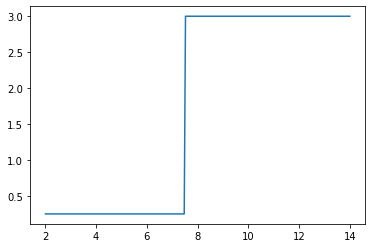

In [19]:
fig, ax = plt.subplots(1,1)
plt.plot(switch["Objective_val"])
ax

## Solution Space (sampling)

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp6iey01ll.lp
Reading time = 0.00 seconds
: 25 rows, 58 columns, 168 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpzt14x_9u.lp
Reading time = 0.00 seconds
: 25 rows, 58 columns, 168 nonzeros


Text(0.5, 0, 'FBP flux')

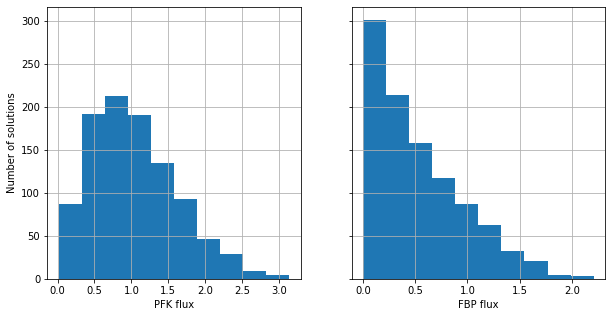

In [20]:
combined =trial.copy()
combined.objective= "ATPM"
df = cobra.sampling.sample(combined, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['PFK'].hist(ax=ax)
ax.set_xlabel('PFK flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['FBP'].hist(ax=ax)
ax.set_xlabel('FBP flux')

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpoo_qlqk9.lp
Reading time = 0.00 seconds
: 25 rows, 58 columns, 168 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpindg_0un.lp
Reading time = 0.00 seconds
: 25 rows, 58 columns, 168 nonzeros


Text(0.5, 0, 'FBP flux')

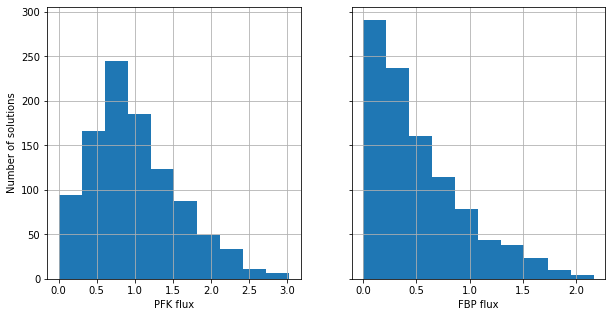

In [21]:
combined =trial.copy()
combined.objective= "EX_glc__D"
df = cobra.sampling.sample(combined, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['PFK'].hist(ax=ax)
ax.set_xlabel('PFK flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['FBP'].hist(ax=ax)
ax.set_xlabel('FBP flux')

## FVA analysis

In [22]:
def plot_fva(atpm_values, max_pfk_values, max_fbp_values, min_pfk_values, min_fbp_values):
    """
    Parameters
    ----------
    atpm_values : list
        list of ATPM flux values from 0 to max
        
    max_g6pdh_values : list
        list of maximum G6PDH2r flux values at the ATPM fluxes in atpm_values
    max_pgi_values : list
        list of maximum PGI flux values at the ATPM fluxes in atpm_values

    min_g6pdh_values : list 
        list of minimum G6PDH2r flux values at the ATPM fluxes in atpm_values

    min_pgi_values : list
        list of minimum PGI flux values at the ATPM fluxes in atpm_values

    """
    plt.fill_between(atpm_values, max_pfk_values, min_pfk_values, 
                     label='Glycolysis', alpha=.7)
    plt.fill_between(atpm_values, max_fbp_values, min_fbp_values, 
                     label='Gluconeogenesis', alpha=.7)
    plt.legend()
    plt.xlabel('ATPM flux')
    plt.ylabel('Range of possible fluxes')

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpp3jkazu1.lp
Reading time = 0.00 seconds
: 25 rows, 58 columns, 168 nonzeros


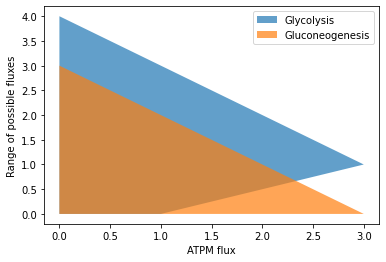

In [23]:
combined = trial.copy()
rxn = 'ATPM'
var_rxn = 'PFK'
var_rxn_2 = 'FBP'
combined.objective = rxn
obj = combined.optimize().objective_value
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpwyjk0hqw.lp
Reading time = 0.00 seconds
: 25 rows, 58 columns, 168 nonzeros
0.25


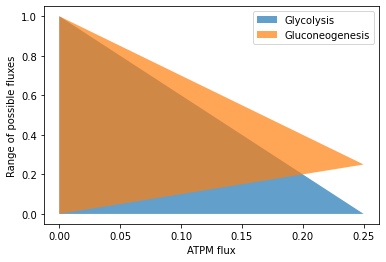

In [24]:
combined = trial.copy()
rxn = "EX_glc__D"
var_rxn = 'PFK'
var_rxn_2 = 'FBP'
combined.objective = rxn
obj = combined.optimize().objective_value
print(obj)
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpfyaeiho8.lp
Reading time = 0.00 seconds
: 25 rows, 58 columns, 168 nonzeros
3.0


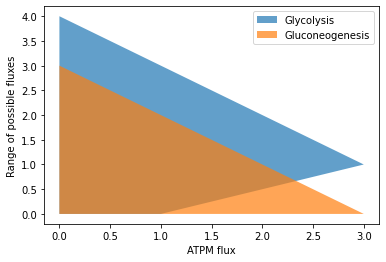

In [25]:
combined = trial.copy()
rxn = "ATPM"
var_rxn = 'HEX1'
var_rxn_2 = 'G6PP'
combined.objective = rxn
obj = combined.optimize().objective_value
print(obj)
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

In [30]:
# trial.problem.Constraint

optlang.gurobi_interface.Constraint

In [26]:
# same_flux = trial.problem.Constraint(
#     trial.reactions.PFK.flux_expression - trial.reactions.FBP.flux_expression,
#     lb=0,
#     ub=1)
# trial.add_cons_vars(same_flux)

In [27]:
# flux_solution = trial.optimize()
# flux_solution

In [28]:
# solution = trial.optimize()
# print(solution.fluxes['FBP'], solution.fluxes['PFK'],
#       solution.objective_value)



In [29]:
from cobra.flux_analysis import flux_variability_analysis

In [30]:
trial.optimize()
trial.summary(fva=0.95)

Metabolite,Reaction,Flux,Range,C-Number,C-Flux
adp,EX_adp,1,[0.85; 1],10,62.50%
glc__D,EX_glc__D,1,[0.925; 1],6,37.50%
h2o,EX_h2o,1,[0.85; 1],0,0.00%
Metabolite,Reaction,Flux,Range,C-Number,C-Flux
amp,EX_amp,-1,[-1; -0.85],10,62.50%
co2,EX_co2,0,[-998.1; 0],1,0.00%
gdp,EX_gdp,0,[-998.1; 0],10,0.00%
gtp,EX_gtp,0,[0; 998.1],10,0.00%
h,EX_h,-3,[-3; -2.85],0,0.00%
hco3,EX_hco3,0,[0; 998.1],1,0.00%


In [31]:
flux_variability_analysis(trial, trial.reactions)

,minimum,maximum
HEX1,1.0,1.0
PGI,1.0,1.0
FBP,0.0,0.0
PFK,1.0,1.0
FBA,1.0,1.0
TPI,1.0,1.0
GAPD,2.0,2.0
PGK,-2.0,-2.0
PGM,-2.0,-2.0
ENO,2.0,2.0


In [32]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}


#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_2.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 1.0, 'PGI': 1.0, 'FBP': 0.0, 'PFK': 1.0, 'FBA': 1.0, 'TPI': 1.0, 'GAPD': 2.0, '…

In [33]:
# trial.objective = 'ATPM'
# fba_solution = trial.optimize()
# pfba_solution = cobra.flux_analysis.pfba(trial)
# pfba_solution


In [34]:
# geometric_fba_sol = cobra.flux_analysis.geometric_fba(trial)
# geometric_fba_sol

In [35]:

from cobra.sampling import sample

# model = load_model("textbook")
s = sample(trial, 100)
# s.head()
s


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpgnupqs_i.lp
Reading time = 0.00 seconds
: 25 rows, 58 columns, 168 nonzeros


,HEX1,PGI,FBP,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,...,EX_h2o,EX_h,EX_pi,EX_lac__L,EX_co2,EX_hco3,EX_gtp,EX_amp,EX_gdp,EX_adp
0,0.853157,0.768831,0.896668,1.665500,0.768831,0.768831,1.537662,-1.537662,-1.537662,1.537662,...,-0.374957,1.912620,433.139074,1.537662,432.764117,-432.764117,-432.764117,0.374957,432.764117,-0.374957
1,1.253622,0.521109,0.767299,1.288408,0.521109,0.521109,1.042218,-1.042218,-1.042218,1.042218,...,-0.473792,1.516010,223.185106,1.042218,222.711314,-222.711314,-222.711314,0.473792,222.711314,-0.473792
2,1.987445,0.716650,0.607494,1.324145,0.716650,0.716650,1.433301,-1.433301,-1.433301,1.433301,...,-0.765499,2.198800,753.655469,1.433301,752.889970,-752.889970,-752.889970,0.765499,752.889970,-0.765499
3,1.133198,0.846634,1.446908,2.293542,0.846634,0.846634,1.693269,-1.693269,-1.693269,1.693269,...,-0.339550,2.032819,148.911288,1.693269,148.571738,-148.571738,-148.571738,0.339550,148.571738,-0.339550
4,2.322326,0.890066,0.185059,1.075125,0.890066,0.890066,1.780132,-1.780132,-1.780132,1.780132,...,-0.650281,2.430413,531.096175,1.780132,530.445894,-530.445894,-530.445894,0.650281,530.445894,-0.650281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.041798,0.479961,0.108533,0.588494,0.479961,0.479961,0.959923,-0.959923,-0.959923,0.959923,...,-0.578415,1.538338,531.878980,0.959923,531.300565,-531.300565,-531.300565,0.578415,531.300565,-0.578415
96,0.889502,0.544634,0.265929,0.810563,0.544634,0.544634,1.089268,-1.089268,-1.089268,1.089268,...,-0.929089,2.018357,371.198036,1.089268,370.268947,-370.268947,-370.268947,0.929089,370.268947,-0.929089
97,0.539936,0.479709,0.348889,0.828598,0.479709,0.479709,0.959418,-0.959418,-0.959418,0.959418,...,-0.919951,1.879369,139.320951,0.959418,138.400999,-138.400999,-138.400999,0.919951,138.400999,-0.919951
98,1.605215,0.839826,0.667804,1.507630,0.839826,0.839826,1.679652,-1.679652,-1.679652,1.679652,...,-0.795685,2.475337,424.827238,1.679652,424.031553,-424.031553,-424.031553,0.795685,424.031553,-0.795685


In [36]:

from cobra.io import json
import cobra.test
import os
from os.path import join
from glob import glob

In [37]:
gly_gluco_json = os.path.join(model_dir,"glycolysis_gluconeogenesis_no_cmpt.json")
json.save_json_model(model=trial, filename=gly_gluco_json)

In [43]:
# import cplex 
# import gurobipy 

In [38]:
# for model_file in glob(gly_gluco_json):
#     model_name = model_file.split('/')[-1]
#     if 'model' not in model_name:
#         continue
#     print(model_name)
#     model= load_json_model(model_file)
#     if 'NADPHM' in model.reactions:
#         model.remove_reactions(['NADPHM'])
#     # media = ['EX_lac__L_c', 'EX_pyr_c', 'EX_octa_c', 'EX_gln__L_c', 'EX_acetone_c', 'EX_bhb_c',
#     #          'EX_glu__L_c', 'EX_ser__L_c', 'EX_cys__L_c', 'EX_gly_c', 'EX_ala__L_c', 'EX_so3_c',
#     #         'EX_etoh_c', 'EX_fru_c']
#     media = ['EX_glc__D_c']
#     for met in media:
#         if met in model.reactions:
#             model.reactions.get_by_id(met).lower_bound = -1000.

#     rxns = [i.id for i in model.reactions]
#     # removed blocke reactions because it included ['PEPCKm', 'PCm', 'PYRt2m', 'ADK1', 'PEPtm', 'EX_h2o_c', 'EX_pi_c']
#     # blocked = cobra.flux_analysis.find_blocked_reactions(model)
#     # print(blocked)
#     # model.remove_reactions(blocked)

#     solved_fluxes = minspan(model, cores=3, verbose=False, timelimit=60)
    
#     df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
#     df = df/df.abs().max()
#     for col in range(len(df.columns)):
#         column=df.iloc[:,col]
#         vals = column.values
#         min_val = min([abs(i) for i in vals if i != 0])
#         corr_fac=1/min_val
#         # print(corr_fac)
#         vals=vals*abs(corr_fac)
#         df['Norm'+ str(col)]=vals
#     csv_dir = os.path.join(minspan_dir,"gly_gluco_csv.csv")
#     df.to_csv(csv_dir)
#     # csv_minspan_dir = os.path.join(minspan_dir,"liver_csv_minspan.csv")
# ## WHere it's stored
# csv_minspan_dir = os.path.join(minspan_dir,"gly_gluco_csv.csv")

In [ ]:
# solved_fluxes = minspan(gluco, cores=3, verbose=False, timelimit=60)

# df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in gluco.reactions])
# df = df/df.abs().max()
# for col in range(len(df.columns)):
#     column=df.iloc[:,col]
#     vals = column.values
#     min_val = min([abs(i) for i in vals if i != 0])
#     corr_fac=1/min_val
#     # print(corr_fac)
#     vals=vals*abs(corr_fac)
#     df['Norm'+ str(col)]=vals
# csv_dir = os.path.join(minspan_dir,"gluco_csv.csv")
# df.to_csv(csv_dir)

In [39]:
# making dataframe 
# df = pd.read_csv(csv_minspan_dir,index_col=0) 
# df

In [40]:
import escher
from escher import Builder

In [41]:
# initial_minspan_data = {
#     reaction: flux
#     for reaction, flux in df.iloc[:,18].iteritems()}

In [42]:
# #view all the reactions that we need build
# escher_builder = escher.Builder(
#     model=trial,
#     map_json=os.path.join(
#         maps_dir,"Glycolysis_Gluconeogenesis.json")
#     , reaction_data=initial_flux_data)


# New instance to prevent modifications to the existing maps
# escher_builder = Builder(
#     model=trial,
#     map_json=os.path.join(
#         maps_dir,"Glycolysis_Gluconeogenesis_2.json"),
#     reaction_data=initial_minspan_data)

# # Display map in notebook
# escher_builder

In [ ]:
# from cobra.io import json

In [43]:
# core_json = os.path.join(model_dir,"Glycolysis_Gluconeogenesis.json")
# json.save_json_model(model=trial, filename=core_json)

In [89]:
trial.objective = "EX_glc__D"
flux_solution = trial.optimize()
flux_solution.fluxes

HEX1         0.00
PGI         -0.25
FBP          0.25
PFK          0.00
FBA         -0.25
TPI         -0.25
GAPD        -0.50
PGK          0.50
PGM          0.50
ENO         -0.50
PEPCKm       0.50
PYK          0.00
PCm          0.50
LDH_L        0.50
ADK1        -1.00
ATPM         0.00
NADHM        0.00
G6PP         0.25
EX_glc__D    0.25
EX_h2o      -1.00
EX_h         0.50
EX_pi        1.50
EX_lac__L   -0.50
EX_co2       0.50
EX_hco3     -0.50
EX_gtp      -0.50
EX_amp       1.00
EX_gdp       0.50
EX_adp      -1.00
Name: fluxes, dtype: float64

### Making Df of metabolites and reactions, exporting them, and importing to form MASS model

In [90]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [91]:
met_df=pd.DataFrame()
for met in trial.metabolites:
    cobra_met= trial.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    met_df=pd.concat([met_df, df_2])
met_df=met_df.set_index('id')
met_df

,name,charge,formula,compartment
id,,,,
amp,AMP C10H12N5O7P,-2,C10H12N5O7P,
lac__L,L-Lactate,-1,C3H5O3,
hco3,Bicarbonate,-1,CHO3,
pyr,Pyruvate,-1,C3H3O3,
oaa,Oxaloacetate,-2,C4H2O5,
gtp,GTP C10H12N5O14P3,-4,C10H12N5O14P3,
gdp,GDP C10H12N5O11P2,-3,C10H12N5O11P2,
co2,CO2 CO2,0,CO2,
pep,Phosphoenolpyruvate,-3,C3H2O6P,


In [92]:
csv_met_cobra = os.path.join(data_dir,"gly_gluco_no_cmpt_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [93]:
rxn_df=pd.DataFrame()
for rxn in trial.reactions:
    cobra_rxn= trial.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    rxn_df= pd.concat([rxn_df, df])
rxn_df=rxn_df.set_index('id')
# rxn_df

In [94]:
json_rxn_cobra = os.path.join(data_dir,"gly_gluco_no_cmpt_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra,orient="index")

## Making MASS model of glycolysis

In [95]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model from COBRA model

In [96]:
# making dataframe of metabolites
import json
met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

In [97]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [98]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [99]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x01ff41282ee0
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg <=> 2pg 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


## Setting initial conditions

In [100]:
import csv
import openpyxl

In [101]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [102]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations3_no_cmpt.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)
ic_info_all

,ID,Name,Concentration (mM),Concentration (M),Additional Notes
0,13dpg_c,3-Phospho-D-glyceroyl phosphate,0.000243,2.430000e-07,DATA Source:HEPATOKIN
1,2pg_c,D-Glycerate 2-phosphate/ 2-\nPhosphoglycerate,0.110561,1.105609e-04,NaN
2,3pg_c,3-Phospho-D-glycerate/ 3-\nPhosphoglycerate,0.520630,5.206305e-04,NaN
3,aacoa_m,Acetoacetyl-CoA,0.000608,6.083800e-07,NaN
4,ac_c,Acetate,1.057460,1.057460e-03,NaN
5,acac_m,Acetoacetate,0.833009,8.330088e-04,NaN
6,accoa_c,Acetyl-CoA,0.696662,6.966619e-04,NaN
7,adp_c,ADP C10H12N5O10P2,1.994952,1.994952e-03,NaN
8,akg_c,2-Oxoglutarate/ Alpha-Ketoglutarate,0.638182,6.381818e-04,NaN
9,ala__L_c,L-Alanine,0.290000,2.900000e-04,NaN


In [103]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)
conc_df

,Concentration (M)
ID,
13dpg_c,2.430000e-07
2pg_c,1.105609e-04
3pg_c,5.206305e-04
aacoa_m,6.083800e-07
ac_c,1.057460e-03
acac_m,8.330088e-04
accoa_c,6.966619e-04
adp_c,1.994952e-03
akg_c,6.381818e-04


In [104]:
new_index= []
for i in conc_df.index:
    base = conc_df.index.get_loc(i)
    # print(base)
    l = len(i)
    new = i[:l-2]
    new_index.append(new)
    # print(new)
    # conc_df.index.get_loc(base) = new
    # new_id = i.rpartition("_" + str(met.compartment))[0]

conc_df= conc_df.reset_index(drop=True)
conc_df["ID"] = new_index
conc_df.set_index('ID',drop=True,inplace=True)
conc_df

,Concentration (M)
ID,
13dpg,2.430000e-07
2pg,1.105609e-04
3pg,5.206305e-04
aacoa,6.083800e-07
ac,1.057460e-03
acac,8.330088e-04
accoa,6.966619e-04
adp,1.994952e-03
akg,6.381818e-04


In [105]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            row = [mid,ic_value]
            # column = [ic_value]
            # conc_df.append(row)
            met.ic =  ic_value            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
amp: 0.000365
lac__L: 0.00326183772
pyr: 0.00047999999999999996
oaa: 1.44886e-06
pep: 0.00031
2pg: 0.000110560855
3pg: 0.000520630485
nadh: 4.63542e-06
nad: 0.00182530972
13dpg: 2.43e-07
g3p: 8.783869999999999e-06
dhap: 0.00017689737
pi: 0.0064
fdp: 5.1470825e-05
f6p: 0.00012713765
glc__D: 0.01048280703
g6p: 0.00014000000000000001
atp: 0.004727145980000001
adp: 0.00199495195


In [106]:
# ic_info

### Getting Standard and Physiological Gibbs energies of reactions to get Keq of reactions

In [107]:
met_list = []
liver.boundary_conditions
for reaction in liver.boundary_conditions:
    print(reaction)

In [108]:
# for reaction in liver.boundary:
#     excluded_reactions.append(reaction.id)
#     reaction.Keq=1    # Setting Keq
#     print(reaction,reaction.Keq)

In [109]:
for i in liver.metabolites:
    i.compartment = "cytosol"

In [110]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions
print("Boundary Reactions and Values\n-----------------------------")
excluded_reactions=["ATPM", "NADHM","PYRt2m","PEPtm"]

for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

Boundary Reactions and Values
-----------------------------
EX_glc__D: glc__D <=> 
glc__D_b: 0.01048280703

EX_pi: pi <=> 
pi_b: 0.0064

EX_lac__L: lac__L <=> 
lac__L_b: 0.00326183772

EX_amp: amp <=> 
amp_b: 0.000365

EX_adp: adp <=> 
adp_b: 0.00199495195



In [111]:
reaction_str= []
cc = ComponentContribution()
# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import *
Keq_df=pd.DataFrame(columns=["Reaction","Keq"])
# Keq_df

In [112]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id
            # new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id
            # new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        # print(reaction_to_parse)
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
    #         print(f"ΔG'° = {dG0_prime}")
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
    #     print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")
#         list_keq=[reaction,a]
#         rxn_keq=pd.DataFrame(list_keq)
        # df = pd.DataFrame([[reaction,a]], columns=["Reaction","Keq"])
        # Keq_df.append(df)

# Keq_df    

HEX1
Keq = 4959.419292148073
PGI
Keq = 0.34798040939490554
FBP
Keq = 115004.76795942851
PFK
Keq = 1454.9063091036724
FBA
Keq = 0.1620181301040788
TPI
Keq = 0.11365701527311964
GAPD
Keq = 0.0006723795415727605
PGK
Keq = 1943.5298920087905
PGM
Keq = 0.17239894103513229
ENO
Keq = 4.332330471156045
PEPCKm
Keq = 5.8718785452391975
PYK
Keq = 10333.2896179346
PCm
Keq = 26.659254851731617
LDH_L
Keq = 0.00013815091719569572
ADK1
Keq = 2.412316406985432e-235
G6PP
Keq = 33738.05532960206


In [113]:
liver.reactions.NADHM.Keq=1e6
liver.reactions.ATPM.Keq=1e6
# liver.reactions.PEPtm.Keq=1
# liver.reactions.PYRt2m.Keq=1

In [114]:
print("Equilibrium Constants\n---------------------")
for reaction in liver.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

Equilibrium Constants
---------------------
Keq_HEX1: 4959.419292148073
Keq_PGI: 0.34798040939490554
Keq_FBP: 115004.76795942851
Keq_PFK: 1454.9063091036724
Keq_FBA: 0.1620181301040788
Keq_TPI: 0.11365701527311964
Keq_GAPD: 0.0006723795415727605
Keq_PGK: 1943.5298920087905
Keq_PGM: 0.17239894103513229
Keq_ENO: 4.332330471156045
Keq_PEPCKm: 5.8718785452391975
Keq_PYK: 10333.2896179346
Keq_PCm: 26.659254851731617
Keq_LDH_L: 0.00013815091719569572
Keq_ADK1: 2.412316406985432e-235
Keq_ATPM: 1000000.0
Keq_NADHM: 1000000.0
Keq_G6PP: 33738.05532960206
Keq_EX_glc__D: 1
Keq_EX_h2o: 1
Keq_EX_h: 1
Keq_EX_pi: 1
Keq_EX_lac__L: 1
Keq_EX_co2: 1
Keq_EX_hco3: 1
Keq_EX_gtp: 1
Keq_EX_amp: 1
Keq_EX_gdp: 1
Keq_EX_adp: 1


##  Set Fluxes

In [115]:
flux_solution

,fluxes,reduced_costs
HEX1,0.00,-0.5
PGI,-0.25,-0.0
FBP,0.25,0.0
PFK,0.00,-0.5
FBA,-0.25,-0.0
...,...,...
EX_hco3,-0.50,0.0
EX_gtp,-0.50,0.0
EX_amp,1.00,0.5
EX_gdp,0.50,0.0


In [116]:
flux_solution

,fluxes,reduced_costs
HEX1,0.00,-0.5
PGI,-0.25,-0.0
FBP,0.25,0.0
PFK,0.00,-0.5
FBA,-0.25,-0.0
...,...,...
EX_hco3,-0.50,0.0
EX_gtp,-0.50,0.0
EX_amp,1.00,0.5
EX_gdp,0.50,0.0


In [117]:
reaction_list=[]
for reaction in liver.reactions:
    reaction_list.append(reaction.id)


In [118]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 0.0
v_PGI: -0.31965125
v_FBP: 0.31965125
v_PFK: 0.0
v_FBA: -0.31965125
v_TPI: -0.31965125
v_GAPD: -0.6393025
v_PGK: 0.6393025
v_PGM: 0.6393025
v_ENO: -0.6393025
v_PEPCKm: 0.6393025
v_PYK: 0.0
v_PCm: 0.6393025
v_LDH_L: 0.6393025
v_ADK1: -1.278605
v_ATPM: 0.0
v_NADHM: 0.0
v_G6PP: 0.31965125
v_EX_glc__D: 0.31965125
v_EX_h2o: -1.278605
v_EX_h: 0.6393025
v_EX_pi: 1.9179075
v_EX_lac__L: -0.6393025
v_EX_co2: 0.6393025
v_EX_hco3: -0.6393025
v_EX_gtp: -0.6393025
v_EX_amp: 1.278605
v_EX_gdp: 0.6393025
v_EX_adp: -1.278605


## Set H2O/H Constants

In [119]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h",
#     'h_e',
# 'h_m',
#     'h2o_r','h2o_e',
    "h2o",
#     "glc__D_e", "pi_e",
# 'pi_m',
    'pi'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [120]:
for metabolite in [
    'h',
# "h_c", 
#     'h_e',
"h2o",
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [121]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h",'h2o',
    
#         'h_e',
#  'h_m',
#     'h2o_r','h2o_e',
        'pi',
    # 'pi_c',
#     "pi_e",
"glc__D",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
    excluded_reactions=[
        # "Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1',
'PYRt2m','PEPtm',
'NADHM','ATPM',
'CO2tm', 'ATPtm', 'Htm','PIt2m'
    # 'L_LACt2r','PYRt2'
    ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

mass\thermo\conc_solver.py:252 UserWarning: Could not set `excluded_reactions` due to the following: Invalid reaction identifiers in ['PYRt2m', 'PEPtm', 'CO2tm', 'ATPtm', 'Htm', 'PIt2m']
['HEX1', 'PFK', 'PYK', 'ATPM', 'NADHM']
['HEX1', 'PFK', 'PYK', 'ATPM', 'NADHM']
mass\thermo\conc_solution.py:98 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
mass\thermo\conc_solution.py:99 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,variables,reduced_costs
amp,0.031499,0.0
lac__L,0.010589,0.0
hco3,0.001827,0.0
pyr,0.000148,0.0
oaa,0.000006,0.0
...,...,...
Keq_EX_hco3,1.000000,0.0
Keq_EX_gtp,0.242048,0.0
Keq_EX_amp,86.298015,0.0
Keq_EX_gdp,4.131419,0.0


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'udp', 'crn', 'succoa', 'acac', 'ac', 'glyc3p', 'asp__L', 'arg__L', 'aacoa', 'udpg', 'ru5p__D', 'mal__L', 'glu__L', 'coa', 'e4p', 'nadp', 'accoa', 'pi', 'glc__D', 'utp', 'nh4', 'r5p', 'icit', 'cit', 'g1p', 'f1p', 'glyc', 'fum', 'urea', 'succ', 'akg', 'cbp', 'ala__L', 'orn', 'argsuc', 's7p', 'bhb', 'citr__L', 'xu5p__D', 'hmgcoa', 'malcoa', 'gln__L'}, only in one set of given values


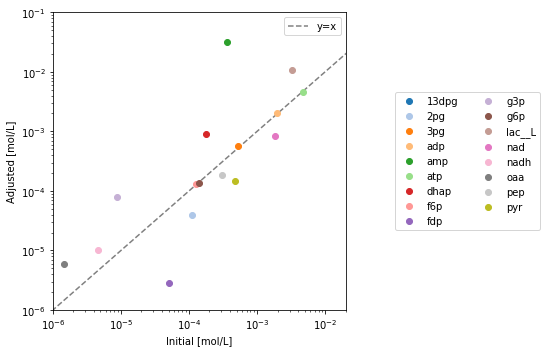

In [122]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration (M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog", 
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True);

In [123]:
liver.boundary

[<MassReaction EX_glc__D at 0x1ff4475c5b0>,
 <MassReaction EX_h2o at 0x1ff4475c790>,
 <MassReaction EX_h at 0x1ff4475c9a0>,
 <MassReaction EX_pi at 0x1ff4475cbb0>,
 <MassReaction EX_lac__L at 0x1ff4475cdc0>,
 <MassReaction EX_co2 at 0x1ff4475cfd0>,
 <MassReaction EX_hco3 at 0x1ff4475c190>,
 <MassReaction EX_gtp at 0x1ff44778430>,
 <MassReaction EX_amp at 0x1ff44778640>,
 <MassReaction EX_gdp at 0x1ff44778850>,
 <MassReaction EX_adp at 0x1ff44778a00>]

In [124]:
# Keq_data = pd.read_csv("./data/analysis_data/equilibrium_constants.csv", index_col=0)

# Keq_data_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# plot_comparison(
#     x=Keq_data["Initial"], y=Keq_data["Adjusted"], ax=ax,
#     title="Equilibrium Constants comparison",
#     legend="right outside", plot_function="loglog",
#     xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), 
#     xy_line=True,
#     xy_legend="best", xlabel="Initial", ylabel="Adjusted")

# Keq_data_comparison_fig.tight_layout()

In [125]:
Boundary= [
    "ATPM",
    
#     'EX_nad_c',
    # "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [126]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
                       )
}, update_reactions=True)
# print(percs)                      

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 100000.000000
kf_PGI: 1346.960991
kf_FBP: 111030.047003
kf_PFK: 100000.000000
kf_FBA: 64616.740147
kf_TPI: 206.985588
kf_GAPD: 3530583.433808
kf_PGK: 284033225.119656
kf_PGM: 1790.430605
kf_ENO: 9346.446771
kf_PEPCKm: 111167.024731
kf_PYK: 100000.000000
kf_PCm: 513888077.247463
kf_LDH_L: 112869.256280
kf_ADK1: 0.000031
kf_ATPM: 100000.000000
kf_NADHM: 100000.000000
kf_G6PP: 2314.491919
kf_EX_glc__D: 1000000.000000
kf_EX_h2o: 1000000.000000
kf_EX_h: 1000000.000000
kf_EX_pi: 1000000.000000
kf_EX_lac__L: 1000000.000000
kf_EX_co2: 1000000.000000
kf_EX_hco3: 1000000.000000
kf_EX_gtp: 1000000.000000
kf_EX_amp: 1000000.000000
kf_EX_gdp: 1000000.000000
kf_EX_adp: 1000000.000000


In [127]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [128]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [129]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: Core_Model                         │
│ SIMULATABLE: False                           │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│           MISSING CONCENTRATIONS             │
│ ============================================ │
│ Boundary Conditions                          │
│ ---------------------                        │
│ co2_b (in EX_co2)                            │
│ gdp_b (in EX_gdp)                            │
│ gtp_b (in EX_gtp)                            │
│ h2o_b (in EX_h2o)                            │
│ h_b (in EX_h)                                │
│ hco3_b (in EX_hco3)                          │
│ ============================================ │
├──────────────────────────────────────────────┤
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ==================

In [131]:
conc_solution.concentrations

amp       0.031499
lac__L    0.010589
hco3      0.001827
pyr       0.000148
oaa       0.000006
gtp       1.519864
gdp       0.657953
co2       0.657953
pep       0.000188
2pg       0.000040
3pg       0.000565
nadh      0.000010
nad       0.000846
13dpg     0.000002
g3p       0.000079
dhap      0.000899
fdp       0.000003
f6p       0.000129
g6p       0.000138
atp       0.004616
adp       0.002043
Name: concentrations, dtype: float64

In [132]:
liver.boundary_conditions['co2_b']=0.657953 ##M
liver.boundary_conditions['gdp_b']=0.657953 ##M
liver.boundary_conditions['gtp_b']=1.519864 ##M
liver.boundary_conditions['h2o_b']=1 ##M
liver.boundary_conditions['h_b']=1 ##M
liver.boundary_conditions['hco3_b']=0.001827 ##M

Successfully loaded MassModel 'Core_Model' into RoadRunner.


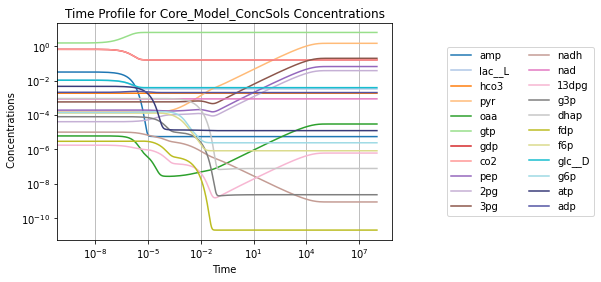

In [133]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [136]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
model_json = os.path.join(model_dir,"Gly_Gluco_no_cmpt.json")
json.save_json_model(mass_model=liver, filename=model_json)

In [137]:
#function to set x label and y label
def set_x_label(xlabel):
    if xlabel==None:
        xlabel="Time"
    else:
        xlabel=xlabel
    return xlabel
        
def set_y_label(ylabel):        
    if ylabel==None:
        ylabel="Concentrations"
    else:
        ylabel=ylabel
    return ylabel


In [138]:
#function to make plot typelinear log
def set_plot_type(plot_type):
    if plot_type == None:
        x_plot_type = 'log'
        y_plot_type = 'log'
    elif plot_type == "logx":
        x_plot_type = 'log'
        y_plot_type = 'linear'
    elif plot_type == "logy":
        x_plot_type = 'linear'
        y_plot_type = 'log'
    elif plot_type == "linear":
        x_plot_type = 'linear'
        y_plot_type = 'linear'
    elif plot_type == "logxlogy":
        x_plot_type = 'log'
        y_plot_type = 'log'
    return x_plot_type,y_plot_type


In [139]:
def view_all_conc_sol(conc_sol,
#                       dynamic=True
                      xlim=None,ylim=None,plot_type=None,xlabel=None,ylabel=None,width=None,height=None):
    """Generate an interactable time profile which can zoom into the plot with interactive tooltip"""
    #Shift click to click multiple
    
    data=conc_sol.to_frame()
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    
    # Setting X limit and Y limit
    def set_ylim(ylim):
        if ylim == None:
            conc=data['Concentrations']
            ylim_max=max(conc)
            ylim=[1e-5,ylim_max]
        else:
            ylim=ylim
        return ylim
    
    def set_xlim(xlim):
        if xlim == None:
            xlim_max=data['Time'].iloc[-1]
            xlim=[1e-5,xlim_max]

        else:
            xlim=xlim
        return xlim
    xlim=set_xlim(xlim)
    ylim=set_ylim(ylim)
        
       
    # Setting type of plot
    x_plot_type=set_plot_type(plot_type)[0]
    y_plot_type=set_plot_type(plot_type)[1]
        
    # Setting x label and y label
    xlabel=set_x_label(xlabel)
    ylabel=set_y_label(ylabel)
    # Setting width and height
    if width==None:
        width=500
    else:
        width=width
        
    if height==None:
        height=300
    else:
        height=height
    
    alt.data_transformers.disable_max_rows()
    selection = alt.selection_multi(fields=['Metabolites'])
    color = alt.condition(selection,
                          alt.Color('Metabolites:N', legend=None),
                          alt.value('lightgray'))

    line = alt.Chart(data).mark_line(clip=True).encode(alt.X('Time:Q',
                                                             title=xlabel,
                                                             scale=alt.Scale(type = x_plot_type,
                                                                             padding = 10,
                                                                             domain = xlim,
#                   zero=True,
                              ),
              axis=alt.Axis(tickCount=5)),
        alt.Y('Concentrations:Q',
              title=ylabel,
              scale=alt.Scale(type=y_plot_type,
                              padding = 10,
                              domain = ylim,
#                   zero=True, 
                             ),
               axis=alt.Axis(grid=False,
                             tickCount=5)),
        color=color,
        tooltip= ["Metabolites"]+["Time"]+["Concentrations"]
    ).properties(width=width, height=height).interactive()

    
    
#         if dynamic == False:
#             A = alt.layer(line)
#         else:
    legend = alt.Chart(data).mark_point().encode(
        y=alt.Y('Metabolites:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )
    A= line | legend
    return A

In [140]:
view_all_conc_sol(conc_sol,plot_type='logxlogy')

alt.HConcatChart(...)